# Estimating Neandertal ancestry over time

In [1]:
library(here)
library(tidyverse)
library(future)
plan(multicore)

library(admixr)
library(bdkn)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
samples <- load_samples() %>%
    filter(!pop %in% c("Africa", "Oceania")) %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset(here("data/genotypes/ice_age.tsv"),
                           here("data/genotypes/sgdp.tsv"),
                           here("data/genotypes/archaics.tsv"),
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha))

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [5]:
EIGENSTRAT_DIR <- here("data/eigenstrat/bigyri_ho/")

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [6]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

## Nea. ancestry proportions using the indirect f4-ratio

In [7]:
merge_labels(IND_FILE,
             paste0(IND_FILE, ".IceAge"),
             pop_labels = list(West_and_Central_Africans = c("Yoruba", "Mbuti", "Mende"),
                               Archaics = c("new_Altai", "new_Denisova")))

In [8]:
iceage_Nea %<-% f4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                        prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

## Nea. ancestry using the direct f4-ratio

More straightforward & should be measuring what we _really_ want to measure.

In [9]:
yoruba %<-% f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
mbuti  %<-% f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
mende  %<-% f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mende", O="Chimp", prefix=EIGENSTRAT)
dinka  %<-% f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [10]:
merge_labels(IND_FILE, paste0(IND_FILE, ".Africans"),
             pop_labels = list(Africans = c("Yoruba", "Mbuti", "Mende", "Dinka")))

In [11]:
africans %<-% f4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Africans", O="Chimp", prefix=EIGENSTRAT,
                      ind=paste0(IND_FILE, ".Africans"))

## qpAdm Neandertal ancestry estimates

In [12]:
qpAdm_df %<-% qpAdm(target = filter(samples, pop %in% c("EMH", "WestEurasia", "EastAsia"))$name,
                    source = c("new_Vindija", "Dinka"),
                    outgroup = c("Chimp", "new_Altai", "new_Denisova"),
                    prefix = EIGENSTRAT)

In [33]:
head(qpAdm_df)

target,nsnps,new_Vindija,Dinka,stderr_new_Vindija,stderr_Dinka
UstIshim,2050585,0.02662380,0.9733762,0.004,0.004
Kostenki14,1676430,0.02315547,0.9768445,0.004,0.004
GoyetQ116-1,811826,0.03314217,0.9668578,0.004,0.004
Muierii2,95793,0.01767066,0.9823293,0.009,0.009
Paglicci133,79635,0.02504458,0.9749554,0.009,0.009
Cioclovina1,12426,0.03675677,0.9632432,0.022,0.022


### Merge all f4 results:

In [34]:
results <- bind_rows(
    inner_join(bind_rows(iceage_Nea %>% mutate(stat = "indirect_f4"),
                         bind_rows(mbuti,  yoruba, mende, dinka, africans) %>% mutate(stat = "direct_f4"),
                         mutate(qpAdm_df, stat = "qpAdm", C = "Mbuti") %>% select(target, stat, C, new_Vindija, stderr = stderr_new_Vindija) %>% rename(X = target, alpha = new_Vindija)),
               snp_counts_f4, by=c("X"="name")) %>% mutate(sites="all"),
    inner_join(direct_nea, snp_counts_direct) %>% rename(X=name) %>% mutate(sites = "admixture_array", stat = "admixture_prop")
) %>%
    inner_join(samples, by=c("X"="name"))

Joining, by = "name"


# Plot Nea. estimates over time

In [15]:
set_dim(9, 5)

In [16]:
non_udg_samples <- NULL #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [17]:
near_east <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew", "Jordanian",
               "Palestinian", "Samaritan", "Yemenite_Jew")

In [18]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% near_east)

## Results from the Ice Age paper

In [19]:
cutoff <- 200000

In [20]:
options(repr.plot.width=9, repr.plot.height=5)

Warning message:
“Removed 48 rows containing missing values (geom_errorbar).”

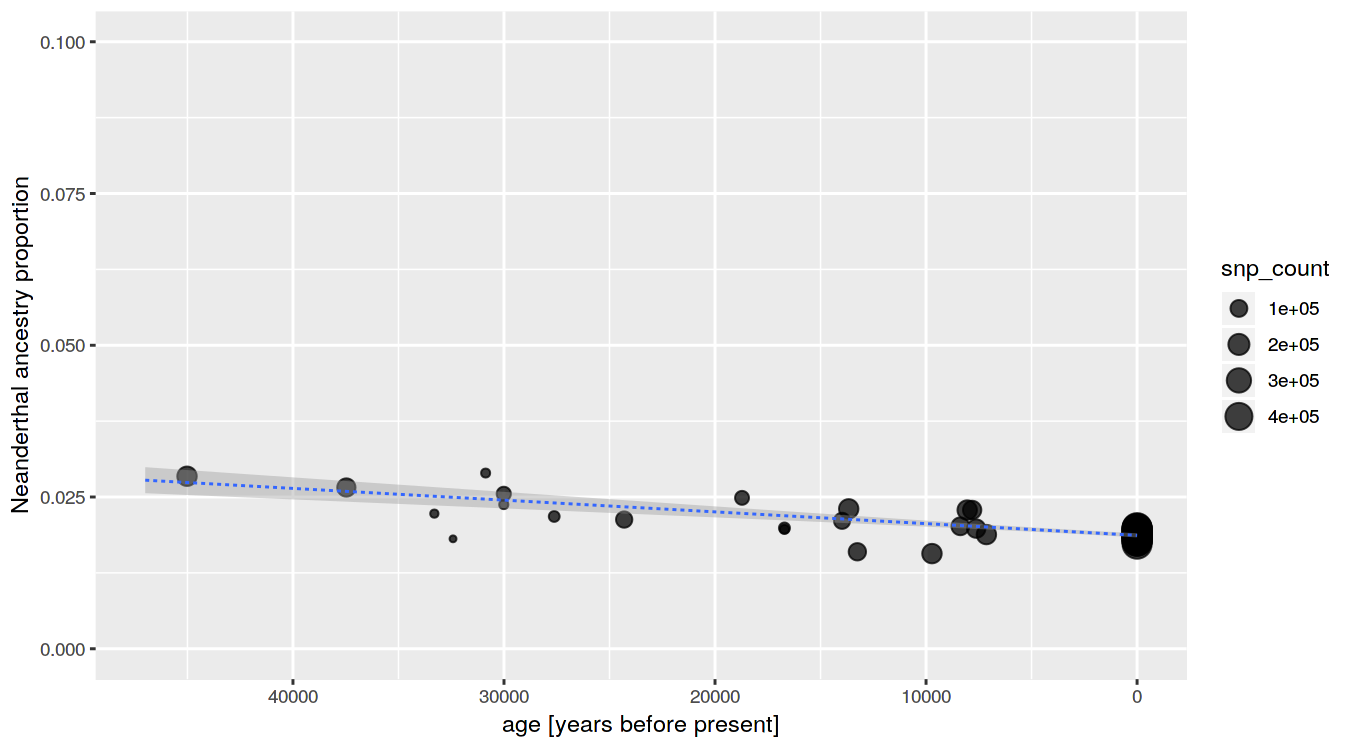

In [21]:
filter(eur_nea, stat == "admixture_prop") %>%
plot_nea_vs_time(snp_cutoff = 2000)

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

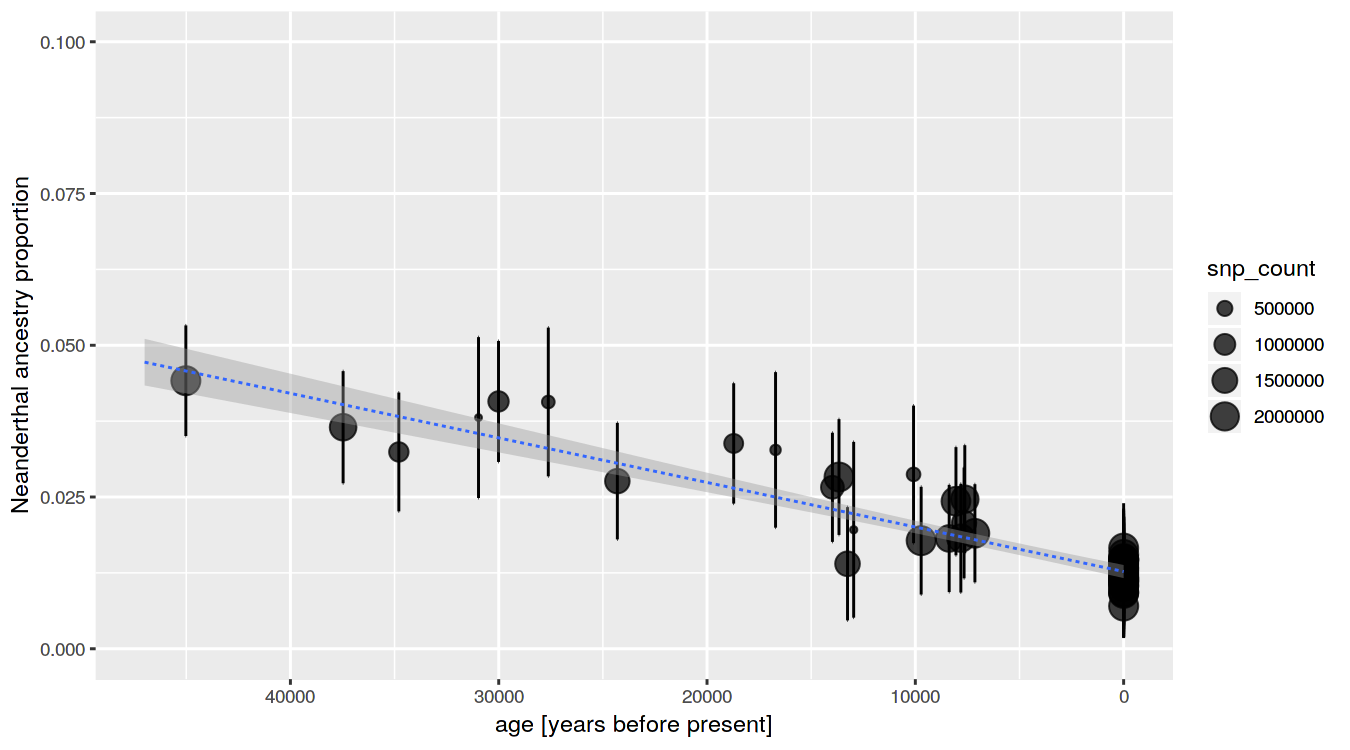

In [22]:
eur_nea %>% filter(A == "West_and_Central_Africans") %>%
plot_nea_vs_time(ylim=c(0, 0.1), snp_cutoff=cutoff)

# qpAdm results


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-14516111  -7624542  -3933120   6730701  53474222 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)    -19998      15195  -1.316   0.1947  
.[["alpha"]]  1068347     631500   1.692   0.0975 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14010000 on 46 degrees of freedom
Multiple R-squared:  0.05857,	Adjusted R-squared:  0.03811 
F-statistic: 2.862 on 1 and 46 DF,  p-value: 0.09746



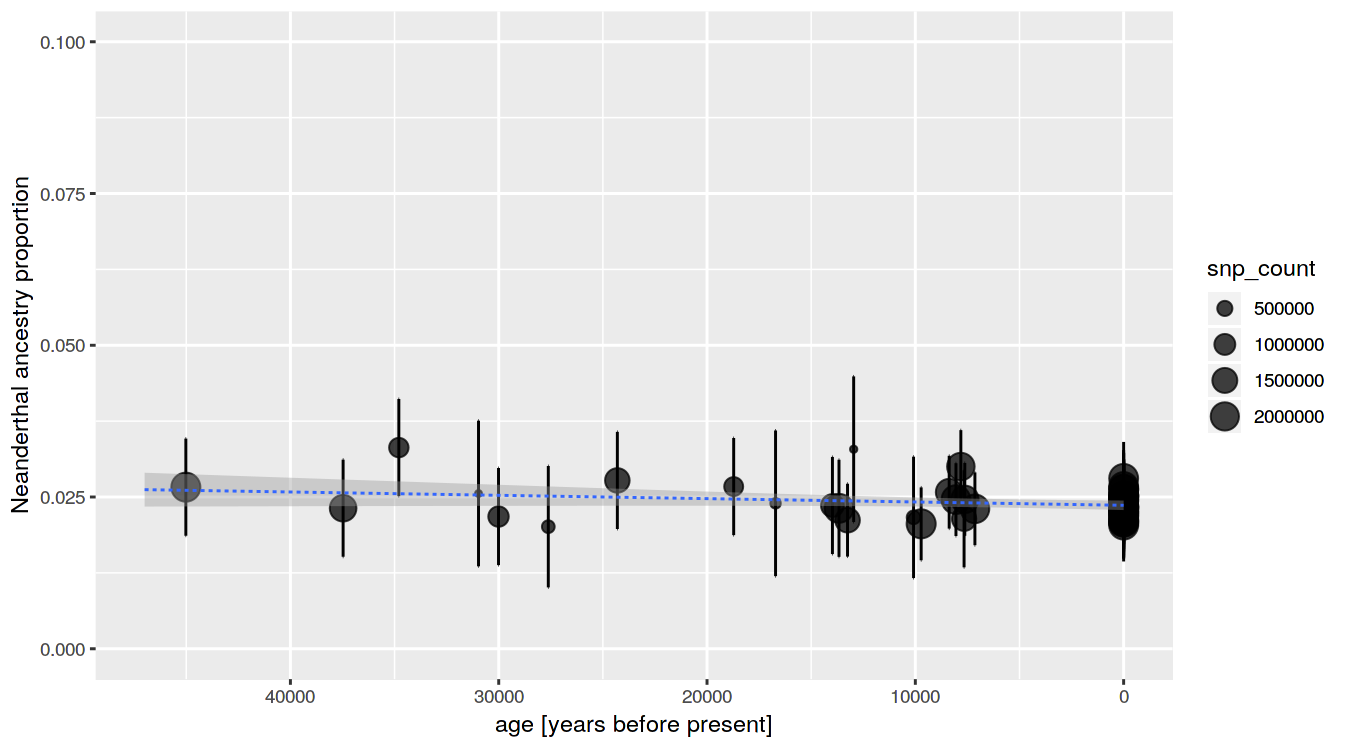

In [23]:
eur_nea %>% filter(stat == "qpAdm") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

qpAdm vs direct f4

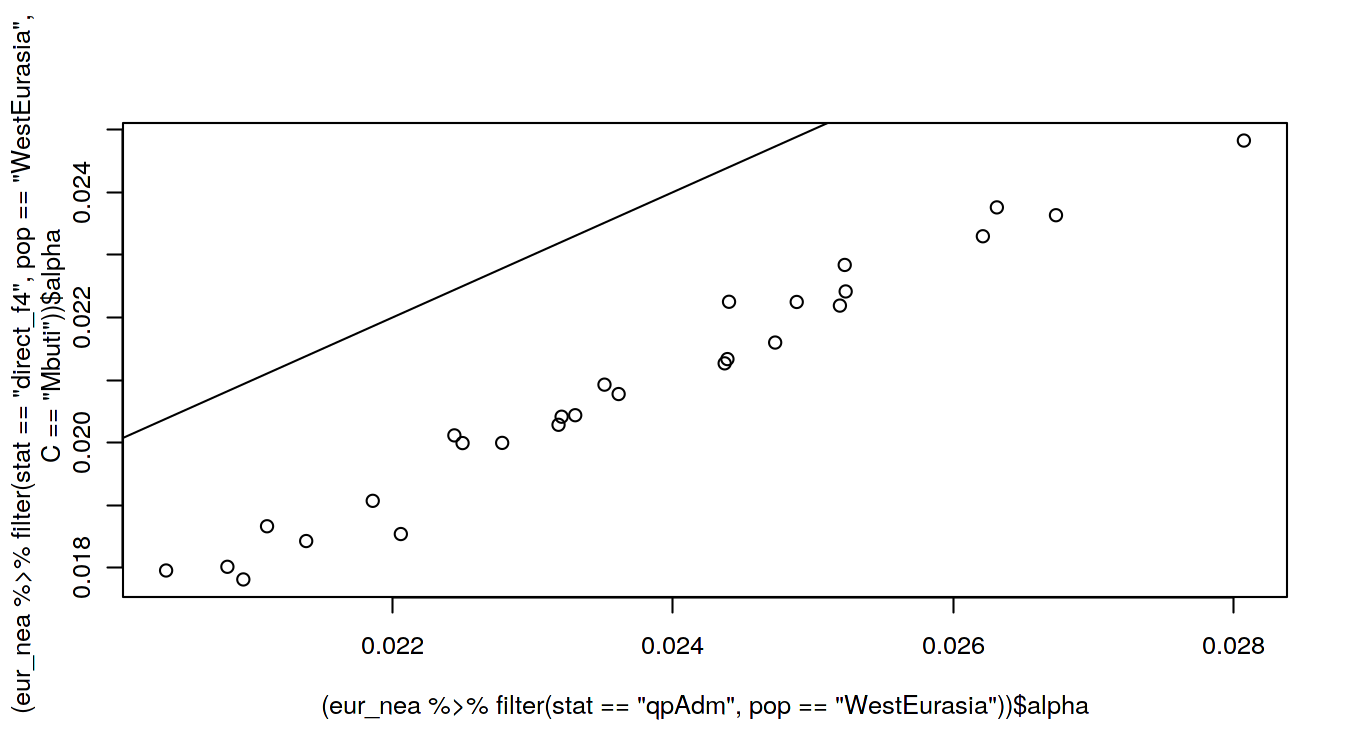

In [24]:
plot(
    (eur_nea %>% filter(stat == "qpAdm", pop == "WestEurasia"))$alpha,
    (eur_nea %>% filter(stat == "direct_f4", pop == "WestEurasia", C == "Mbuti"))$alpha
)
abline(0, 1)

# New f4 results


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8289694 -8143410 -8034622  6085480 57567489 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      4921      14524   0.339    0.736
.[["alpha"]]    28999     636481   0.046    0.964

Residual standard error: 14440000 on 46 degrees of freedom
Multiple R-squared:  4.512e-05,	Adjusted R-squared:  -0.02169 
F-statistic: 0.002076 on 1 and 46 DF,  p-value: 0.9639



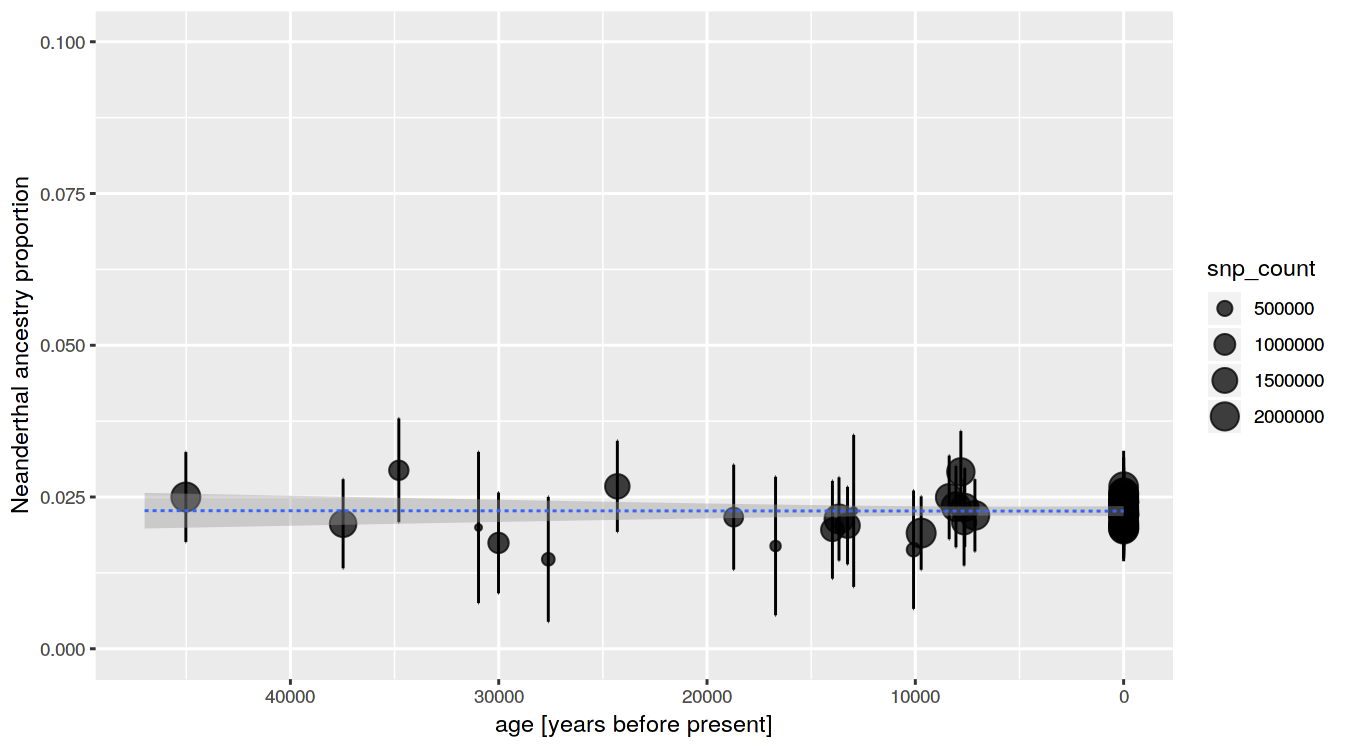

In [25]:
eur_nea %>% filter(stat == "direct_f4", C == "Africans") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-8788806 -8229011 -7503240  5363337 58163448 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      8615      13074   0.659    0.513
.[["alpha"]]  -146381     625792  -0.234    0.816

Residual standard error: 14440000 on 46 degrees of freedom
Multiple R-squared:  0.001188,	Adjusted R-squared:  -0.02053 
F-statistic: 0.05472 on 1 and 46 DF,  p-value: 0.8161



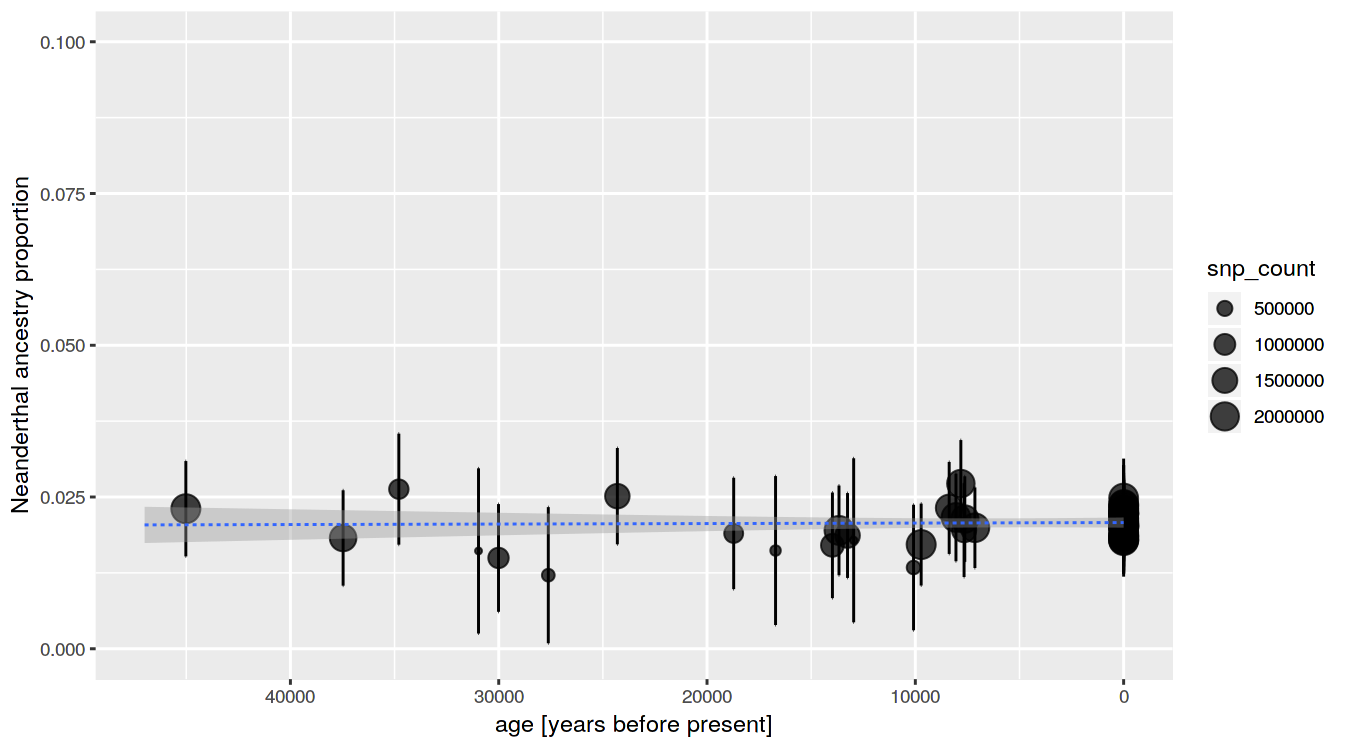

In [26]:
eur_nea %>% filter(stat == "direct_f4", C == "Mbuti") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-11005056  -8036871  -6066908   7352921  56009393 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -6615      14893  -0.444    0.659
.[["alpha"]]   520674     632448   0.823    0.415

Residual standard error: 14340000 on 46 degrees of freedom
Multiple R-squared:  0.01452,	Adjusted R-squared:  -0.006903 
F-statistic: 0.6778 on 1 and 46 DF,  p-value: 0.4146



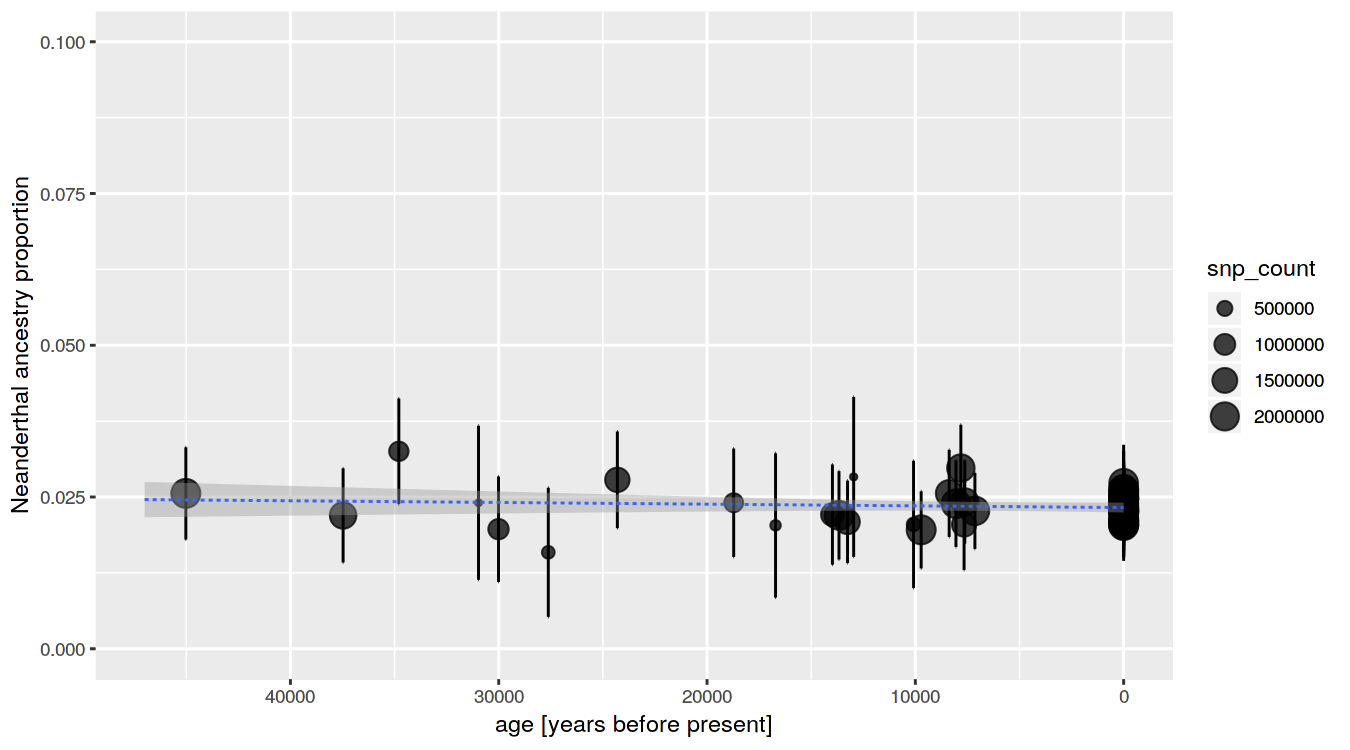

In [27]:
eur_nea %>% filter(stat == "direct_f4", C == "Dinka") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9594141 -8214389 -6672643  5066705 58923835 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     14538      15396   0.944    0.350
.[["alpha"]]  -349217     597025  -0.585    0.561

Residual standard error: 14390000 on 46 degrees of freedom
Multiple R-squared:  0.007383,	Adjusted R-squared:  -0.0142 
F-statistic: 0.3421 on 1 and 46 DF,  p-value: 0.5615



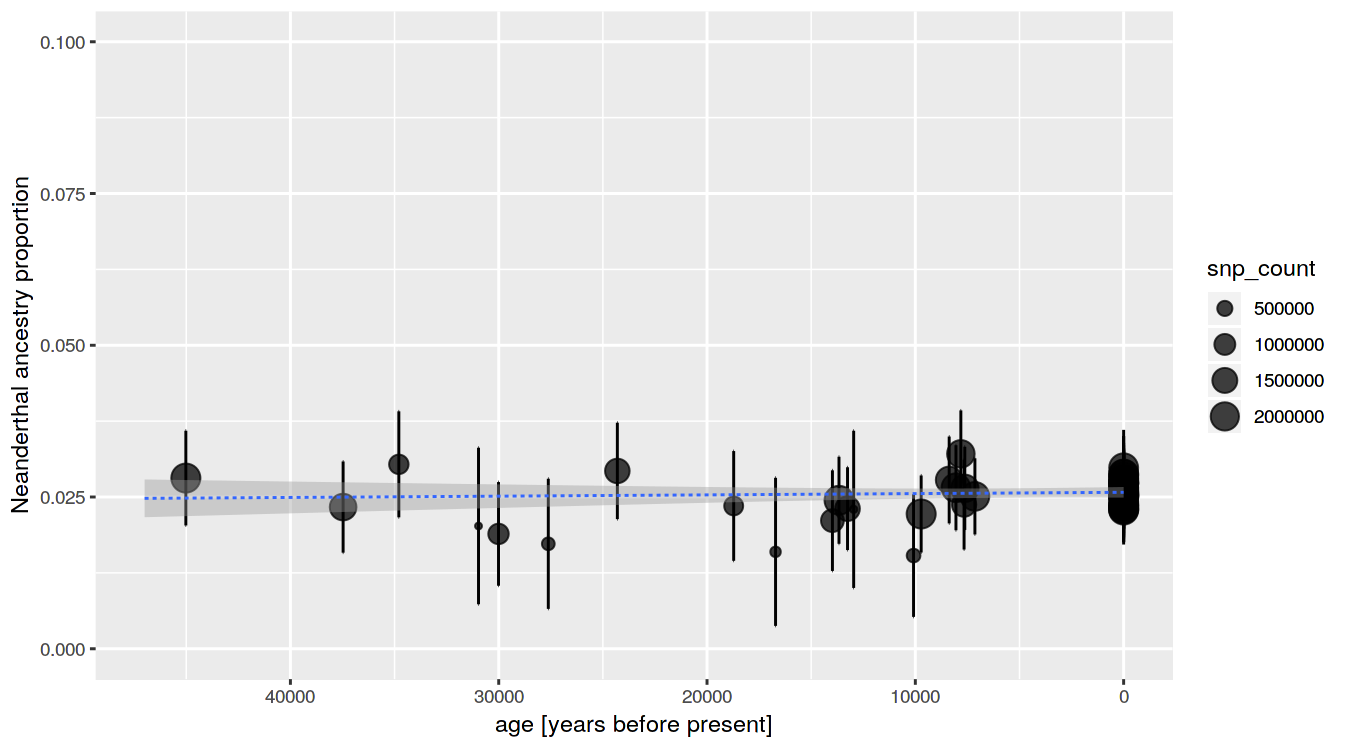

In [28]:
eur_nea %>% filter(stat == "direct_f4", C == "Yoruba") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9878982 -8115975 -6929316  7185522 56621228 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -973.2    13623.0  -0.071    0.943
.[["alpha"]] 311328.4   643048.6   0.484    0.631

Residual standard error: 14410000 on 46 degrees of freedom
Multiple R-squared:  0.00507,	Adjusted R-squared:  -0.01656 
F-statistic: 0.2344 on 1 and 46 DF,  p-value: 0.6306



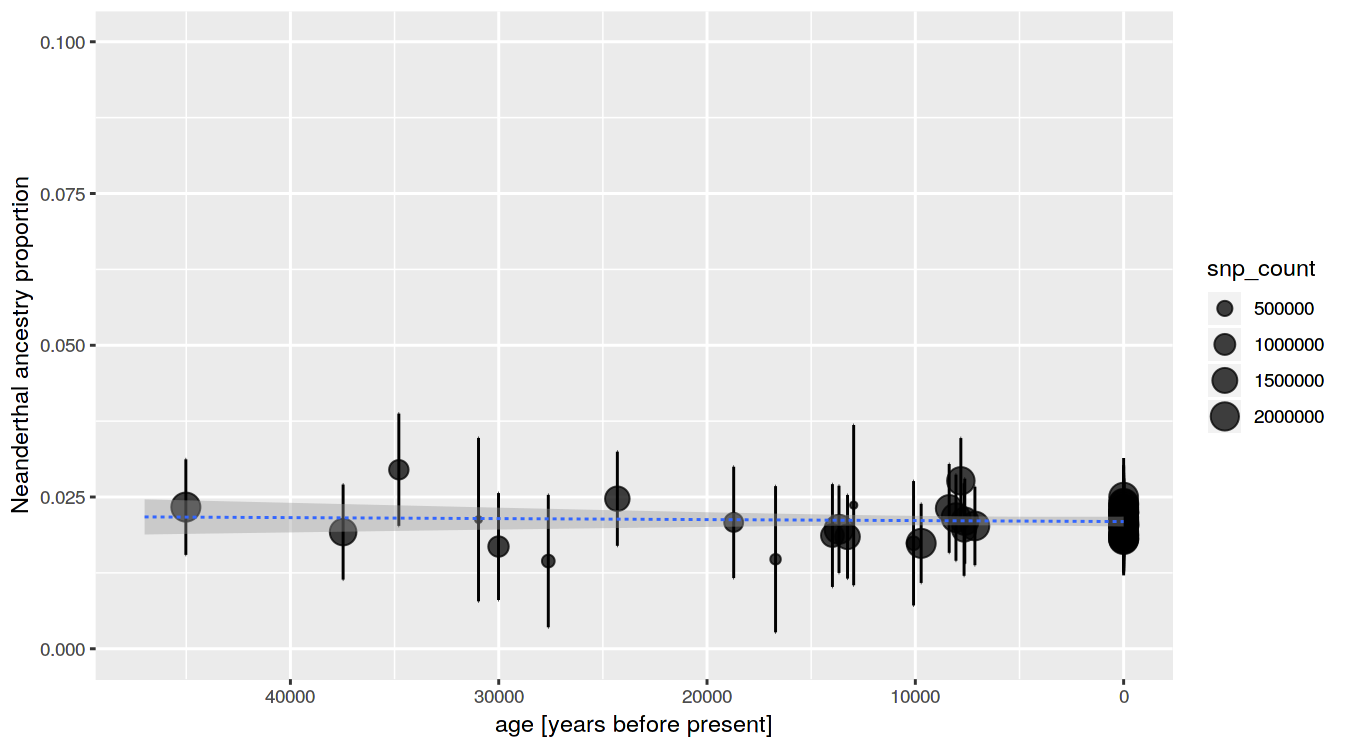

In [29]:
eur_nea %>% filter(stat == "direct_f4", C == "Mende") %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

# Write the admixture array estimates

In [35]:
saveRDS(results, here("data/rds/nea_estimates.rds"))

In [37]:
results <- readRDS(here("data/rds/nea_estimates.rds"))

## Messing around with the indirect f4-ratio tree model

In [43]:
nea1 %<-% f4ratio(X=samples$name, A="Yoruba", B="new_Altai", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [44]:
nea2 %<-% f4ratio(X=samples$name, A="Dinka", B="new_Altai", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)

In [45]:
nea3 %<-% f4ratio(X=samples$name, A="Dinka", B="new_Altai", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)

In [46]:
nea4 %<-% f4ratio(X=samples$name, A="Yoruba", B="new_Altai", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)

In [47]:
nea5 %<-% f4ratio(X=samples$name, A="Mbuti", B="new_Altai", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [48]:
nea <- bind_rows(nea1, nea2, nea3, nea4, nea5) %>%
    inner_join(samples, by = c("X" = "name")) %>%
    mutate(A = "out " %+% A,
           C = "in " %+% C) %>%
    unite(comb, A, C, sep = " x ")

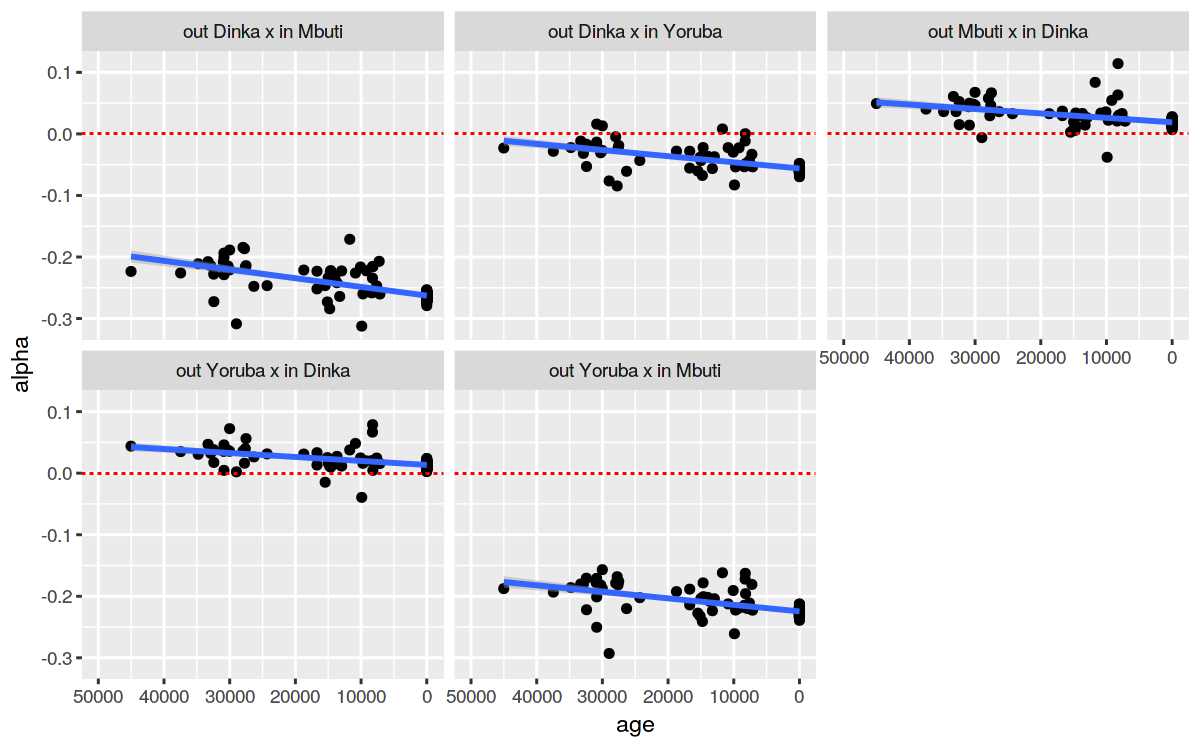

In [52]:
set_dim(8, 5)

ggplot(nea, aes(age, alpha)) + geom_point() + xlim(50000, 0) + facet_wrap(~ comb) + geom_smooth(method = "lm") +
    geom_hline(yintercept = 0, color = "red", linetype = 2)